In [1]:
import os
os.getcwd()

'/Users/alex/Documents/IE/Group assignment-2'

### Import the required libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

### Import the train dataset

In [3]:
data_train = pd.read_csv("modeling_set.csv")

Transform the time_left column to 6 intervals in the train daatset

In [4]:
data_train.time_left = pd.cut(data_train.time_left,bins=[0,50,75,100,125, 150, 175],labels=[1,2,3,4,5,6])

Encode the round_winner column from categorical to numerical

In [5]:
data_train.round_winner = data_train.round_winner.astype('category').cat.codes

Encode the other cotegorical columns to numerical

In [ ]:
categorical_columns = ['map', 'time_left']
columns_to_add = defaultdict(list)
for col in categorical_columns:
    dummies = pd.get_dummies(data_train[col], prefix=col)
    data_train = pd.concat([data_train, dummies], axis=1)
    data_train.drop(col, axis=1, inplace=True)
    columns_to_add[col] += [new_col.replace(col + "_", "") for new_col in dummies.columns]

### Import the test dataset

In [6]:
data_test = pd.read_csv("validation_set.csv")

Transform the time_left column to 6 intervals in the test daatset

In [7]:
data_test.time_left = pd.cut(data_test.time_left,bins=[0,50,75,100,125, 150, 175],labels=[1,2,3,4,5,6])

Encode the round_winner column from categorical to numerical

In [ ]:
data_test.round_winner = data_test.round_winner.astype('category').cat.codes

Encode the other cotegorical columns to numerical

In [8]:
categorical_columns = ['map', 'time_left']
columns_to_add = defaultdict(list)
for col in categorical_columns:
    dummies = pd.get_dummies(data_test[col], prefix=col)
    data_test = pd.concat([data_test, dummies], axis=1)
    data_test.drop(col, axis=1, inplace=True)
    columns_to_add[col] += [new_col.replace(col + "_", "") for new_col in dummies.columns]

### Test that train and test datastes have identical columns

In [12]:
data_train.columns == data_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

### Train and test XGBoost model

In [14]:
train_set = data_train
test_set = data_test

In [15]:
X_train = train_set.drop("round_winner", axis=1)
X_test = test_set.drop("round_winner", axis=1)
y_train = train_set["round_winner"]
y_test = test_set["round_winner"]

In [16]:
import xgboost as xgb

In [17]:
from xgboost import XGBClassifier

In [18]:
import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import GridSearchCV

Train the model including hyperparamater optimisation

In [19]:
%%time
cv_params = {'max_depth': [5,7,9], 'min_child_weight': [1,3,5], 'n_estimators': [200, 300, 400]}
ind_params = {'learning_rate': 0.1, 'random_state':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
              'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, scoring='accuracy', 
                             cv = 5, n_jobs = -1) 
optimized_GBM.fit(X_train, y_train)

CPU times: user 7min 7s, sys: 2.73 s, total: 7min 9s
Wall time: 10h 6min 23s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [200, 300, 400]},
             pre_dispatch=

In [20]:
print(optimized_GBM.best_params_)

{'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 400}


Test the model with the best hyperparamaters on the test dataset

In [21]:
from sklearn.metrics import accuracy_score
y_pred = optimized_GBM.predict(X_test)
print("#Mislabeled points (XGB) : {} out of {}".format(sum(y_pred != y_test), len(y_test)))
print("Model Accuray: {:.4f}".format(accuracy_score(y_test, y_pred)))

#Mislabeled points (XGB) : 4805 out of 36723
Model Accuray: 0.8692


Save the model

In [28]:
import pickle
filename = 'optimized_GBM.sav'
pickle.dump(optimized_GBM, open(filename, 'wb'))

Plot the feature importance

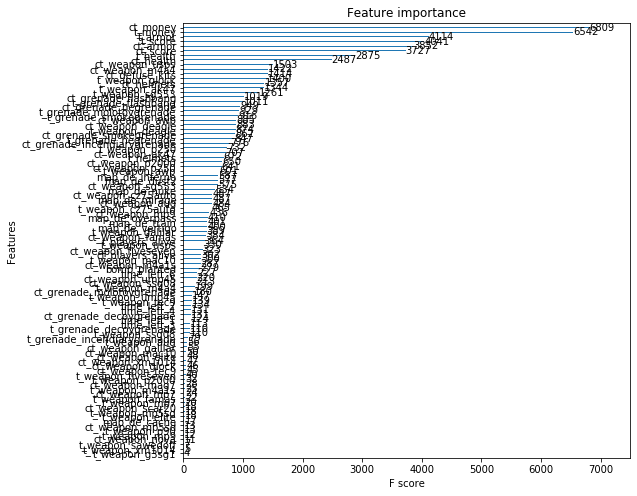

In [23]:
plt.figure(figsize=(8,8))
xgb.plot_importance(optimized_GBM.best_estimator_, ax=plt.gca())
plt.grid(b=None)

### Train and test Random Forrest model

In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, max_features = 'auto', max_depth = 20, criterion = 'entropy', min_samples_split = 3, random_state=0)

Train the model including hyperparamater optimisation

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto'],
    'max_depth' : [10, 20, 30],
    'criterion' :['entropy'], 
    "min_samples_split": [2, 3, 5, 10]
}


In [ ]:
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

Test the model with the best hyperparamaters on the test dataset

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("#Mislabeled points (RF) : {1} out of {0}".format(len(y_test), sum(y_pred != y_test)))
print("Model Accuray: {:.4f}".format(accuracy_score(y_test, y_pred)))

Plot the feature importance

In [ ]:
importances = rf.feature_importances_
print ("Sorted Feature Importance:")
sorted_feature_importance = sorted(zip(importances, list(X_train)), reverse=True)
print (sorted_feature_importance)